<a href="https://colab.research.google.com/github/xslittlemaggie/Deep-Learning-Machine-Learning-Projects/blob/master/Dogs_cats_Kaggle_LH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Step 0. Import the libraries used in this project

In [1]:
# libraries for files
import os
import glob
import cv2

# libraries for image processing and NN models
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.layers import Dense, Activation, Flatten
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


## Step 1. Load data from Kaggle

#### 1. Get the username, key from kaggle

In [0]:
os.environ['KAGGLE_USERNAME'] = "maggie" # username from the json file 
os.environ['KAGGLE_KEY'] = "7aefgec6c4e6c5eec087031fbb7397aee5" # key from the json file

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

#### 2. Find the dataset from Kaggle 

In [0]:
#!pip install kaggle
!pip install -q kaggle

In [0]:
#!kaggle datasets list # It will list 20 datasets from kaggle

In [4]:
!kaggle datasets list -s dogs-vs-cats  # It will list the 20 datasets including "dogs-vs-cats" from kaggle

ref                                                   title                                               size  lastUpdated          downloadCount  
----------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  
nafisur/dogs-vs-cats                                  Dogs_vs_cats                                       217MB  2018-04-25 08:01:49           1363  
biaiscience/dogs-vs-cats                              Dogs vs Cats                                       814MB  2017-12-05 14:03:33           1401  
dhirensk/cats-vs-dogs-training8000test2000            Cats vs Dogs Training8000Test2000                  218MB  2018-11-21 09:38:07            115  
kanwalinder/cats-vs-dogs-redux-transfer-features      Cats vs Dogs Redux Transfer Features                 1GB  2018-08-22 00:46:31             65  
prasunroy/natural-images                              Natural Images                                     1

The dataset of interest is:  **biaiscience/dogs-vs-cats**

#### 3. Get the particular dataset from the previous step, and download data from Kaggle

In [5]:
!kaggle datasets download -d biaiscience/dogs-vs-cats -p /content/

 97% 793M/814M [00:16<00:00, 41.1MB/s]
100% 814M/814M [00:16<00:00, 50.2MB/s]


#### 4.  Upzip data to file

In [0]:
!unzip -q /content/dogs-vs-cats.zip -d /content/dogs-vs-cats/
!unzip -q /content/dogs-vs-cats/train.zip -d /content/dogs-vs-cats/
!unzip -q /content/dogs-vs-cats/test.zip -d /content/dogs-vs-cats/

In [0]:
#!ls /content/dogs-vs-cats/dataset/

#### 5. Get familiar with how the file look like

In [7]:
# train datasets
pathes_train = glob.glob('/content/dogs-vs-cats/train/*.jpg')
print(pathes_train[0])
print("Training size:", len(pathes_train), "\n")

# test datasets
pathes_test = glob.glob('/content/dogs-vs-cats/test/*.jpg')
print(pathes_test[0])
print("Testing size:", len(pathes_test))

/content/dogs-vs-cats/train/cat.3471.jpg
Training size: 25000 

/content/dogs-vs-cats/test/8037.jpg
Testing size: 12500


#### 6. Split the photos in train and test files into cats and dogs, respectively

We get 1 big file, "dogs-vs-cats", and two subfiles **train** file, and **test** file.  
1. The **train** file includes 25000 photos, either cats or dogs. The photos are not labels in this way. 
2. Two subfiles, **cats**, and **dogs**,  are created in **train** file.
3. All images with the file name including **cat** are moved to the **cats** file under **train** file, and all images with the file name including **dog** are moved to the **dogs** file under **train** file.
4. The whole process **3** is repeated for **test** file.

In [0]:
# splits pictures into cats and dogs files for train dataset
os.mkdir("/content/dogs-vs-cats/train/cats")
os.mkdir("/content/dogs-vs-cats/train/dogs")

# splits pictures into cats and dogs files for test dataset
os.mkdir("/content/dogs-vs-cats/test/cats")
os.mkdir("/content/dogs-vs-cats/test/dogs")

In [0]:
pathes = glob.glob('/content/dogs-vs-cats/train/*.jpg')
for path in pathes:
  head, tail = os.path.split(path)
  if tail[:3] == "cat":
    new_path = head + "/cats/" + tail  
  else:
    new_path = head + "/dogs/" + tail
  os.rename(path, new_path)  # move the photos from train file into the subfiles, cats or dogs based on their file name

In [0]:
pathes = glob.glob('/content/dogs-vs-cats/test/*.jpg')
for path in pathes:
  head, tail = os.path.split(path)
  if tail[:3] == "cat":
    new_path = head + "/cats/" + tail  
  else:
    new_path = head + "/dogs/" + tail
  os.rename(path, new_path)

## Step 2. Data preprocessing for training & testing datasets

#### 1. Get familar with the input (image), the width, height, etc. 

In [0]:
DATADIR_train = "/content/dogs-vs-cats/train"
DATADIR_test = "/content/dogs-vs-cats/test"

/content/dogs-vs-cats/train/dogs


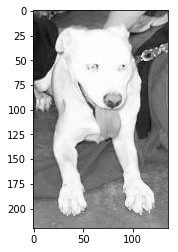

In [0]:
CATEGORIES = ["dogs", "cats"]
for category in CATEGORIES:
    path = os.path.join(DATADIR_train, category)
    print(path)
    for img in os.listdir(path):
        img_array_train = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array_train, cmap = "gray")
        plt.show()
        break
    break

In [0]:
print(img_array_train) 
print("The width, height of this particular image are:", img_array_train.shape)
print("Minimum value of the pixal:", min([min(_) for _ in img_array_train]))  
print("Maximum value of the pixal:", max([max(_) for _ in img_array_train]))

[[139 150 151 ... 112 102  94]
 [142 136 124 ... 100  98  93]
 [149 129 110 ...  98 113 107]
 ...
 [154 157 157 ... 146 144 142]
 [156 160 162 ... 147 145 144]
 [153 159 161 ... 147 146 146]]
The width, height of this particular image are: (220, 136)
Minimum value of the pixal: 20
Maximum value of the pixal: 255


 Get the min, and max for the pixel, for data normalization latter

#### 2. Resize the photo smaller to 50 * 50 for an example and check whether the photo is still visible

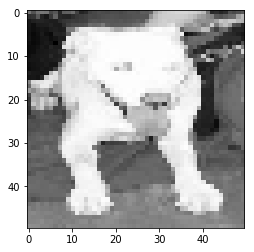

In [0]:
IMG_SIZE = 50
new_array_train_50 = cv2.resize(img_array_train, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array_train_50, cmap = "gray")
plt.show()

The 50 * 50 pixel is not Clear, try 100 * 100

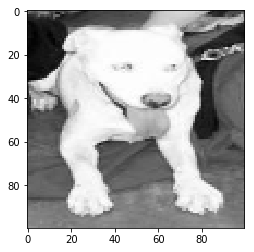

In [0]:
IMG_SIZE = 100
new_array_train_100 = cv2.resize(img_array_train, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array_train_100, cmap = "gray")
plt.show()

100 * 100 looks ok, use the 100 * 100 as the image size for the CNN model

In [0]:
# Transform data into vector, but too big, not practical for big data
"""
training_data = []
def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR_train, category)
        class_num = CATEGORIES.index(category) # get the classification (0, or 1), 0 = dog, 1 = cat
        #print(os.listdir(path)[0]) img: a string like "9733.jpg" 
        for img in os.listdir(path):
            if img[-3:] == "jpg":             
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                if img_array is not None:
                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                    training_data.append([new_array, class_num])    
            #except Exception as e: try not to use except since it will ignore the errors, and difficult to debug
                #pass
os.path.join(path, img)
create_training_data()
print(len(training_data))
"""

'\ntraining_data = []\ndef create_training_data():\n    for category in CATEGORIES:\n        path = os.path.join(DATADIR_train, category)\n        class_num = CATEGORIES.index(category) # get the classification (0, or 1), 0 = dog, 1 = cat\n        #print(os.listdir(path)[0]) img: a string like "9733.jpg" \n        for img in os.listdir(path):\n            if img[-3:] == "jpg":             \n                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)\n                if img_array is not None:\n                    new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))\n                    training_data.append([new_array, class_num])    \n            #except Exception as e: try not to use except since it will ignore the errors, and difficult to debug\n                #pass\nos.path.join(path, img)\ncreate_training_data()\nprint(len(training_data))\n'

**Note**: Considered to transform each photo into a vector (vector dimension = 100 * 100) first. However since the dimension is equal to or bigger than the 100 * 100, and also the sample size is huge (25,000), it is impractical to do this transformation all together.  

The **ImageDataGenerator** is introduced to deal with this problem, which only deals with a small dataset each time (like a batch_size) first instead of transforming the whole datasets all together.

## Step 3. Model building

In [0]:
datagen = ImageDataGenerator(rescale=1./255)  # augumentation to add noise to data: shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True
train_it = datagen.flow_from_directory("/content/dogs-vs-cats/train", class_mode = "binary", target_size = (100, 100), batch_size = 100)
test_it = datagen.flow_from_directory("/content/dogs-vs-cats/test", class_mode = "binary", target_size = (100, 100), batch_size = 100)

batchX, batchy = train_it.next()
print("Batch shape = {}, min = {}, max = {}".format(batchX.shape, batchX.min(), batchX.max()))

Found 25000 images belonging to 2 classes.
Found 12500 images belonging to 2 classes.
Batch shape = (100, 100, 100, 3), min = 0.0, max = 1.0


flow_from_directory parameters:
1. batch_size = 64 (32 by default)
2. class_mode = "binary", ("categorical" for multi-class classification)
3. "shuffle" = False if need to returen batches in a deterministic order when evaluating a model
4. "target_size" = (100, 100 ) ((256, 256) by default)


In [0]:
# define CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3), 
                 activation = 'relu', input_shape = (100, 100, 3)))
model.add(MaxPooling2D(2, 2))
#model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation = 'relu', kernel_initializer='he_uniform'))#kernel_initializer='he_uniform'
model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform'))

model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform'))

model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation = 'relu', kernel_initializer='he_uniform'))

model.add(MaxPooling2D((2, 2)))
#model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_initializer='he_uniform'))
#model.add(Dropout(0.7))

model.add(Dense(1, activation ='softmax'))

#opt = SGD(lr=0.001, momentum=0.9)
model.compile(loss = "sparse_categorical_crossentropy", optimizer = "adam", metrics = ['accuracy'])
model.summary()

W0716 06:27:43.484541 140605947803520 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 64)          3

In [0]:
# fit model
model.fit_generator(train_it, steps_per_epoch = len(train_it), epochs = 14)
# evaluate model
result = model.evaluate_generator(test_it, steps = len(test_it))
print("Test loss:", result[0])
print("Test acc: ", result[1])

Epoch 1/14
250/250 [==============================] - 74s 294ms/step - loss: nan - acc: 0.4999
Epoch 2/14
250/250 [==============================] - 73s 290ms/step - loss: nan - acc: 0.5000
Epoch 3/14
250/250 [==============================] - 72s 290ms/step - loss: nan - acc: 0.5000
Epoch 4/14
250/250 [==============================] - 72s 289ms/step - loss: nan - acc: 0.5000
Epoch 5/14
250/250 [==============================] - 72s 289ms/step - loss: nan - acc: 0.5000
Epoch 6/14
250/250 [==============================] - 72s 288ms/step - loss: nan - acc: 0.5000
Epoch 7/14
250/250 [==============================] - 72s 289ms/step - loss: nan - acc: 0.5000
Epoch 8/14
250/250 [==============================] - 72s 287ms/step - loss: nan - acc: 0.5000
Epoch 9/14
250/250 [==============================] - 71s 286ms/step - loss: nan - acc: 0.5000
Epoch 10/14
250/250 [==============================] - 72s 287ms/step - loss: nan - acc: 0.5000
Epoch 11/14
250/250 [============================

**First time** result analysis:

**Train acc**: 0.98

**Test acc**:  0.47248

This could be caused by the overfitting.
Add the the optimization (dropout), and train the model again.

**Second time** result analysis:
 

### References
URL_1 = "https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/"

URL_2 = "https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/"